In [1]:
import math
import numpy as np
import random
from time import time

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

import optuna

from model import Autoencoder, Regressor
import torch
from torch import nn, optim
from utils import *

# PREPARE FEATURE SETS

In [61]:
IOWA_PATH = '../../datasets/train_data_iowa.csv'
SIMULATION_PATH = '../../datasets/datensatz_emre.csv'

IS_IOWA_DATASET = True  # iowa dataset : true, simulation : false
CSV_PATH = IOWA_PATH if IS_IOWA_DATASET else SIMULATION_PATH

CF_PATH = "../../datasets/crafted_features.csv"

In [86]:
features = [
    "location",
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y", 
    "order_time",
    "etd",
    "restaurant_queue",
    "max_pre_shift",
    "max_post_shift",
    "restaurants_before_customer",
    "customers_before_customer",
    "len_vehicle_route_to_customer",
]

for i in range(23):
    features.append(f"vehicle_route_to_customer_pos_x_{i}")
    features.append(f"vehicle_route_to_customer_pos_y_{i}")
    features.append(f"vehicle_route_to_customer_action_{i}")
    features.append(f"vehicle_route_to_customer_time_action_{i}") 

In [87]:
# Import data
start_time = time()

raw = pd.read_csv(CSV_PATH, header=0, sep=";", usecols=[*features, "atd"])
X = raw.loc[:, raw.columns != 'atd']
y = raw['atd'] - raw['etd']

print(f"Elapsed time: {time() - start_time} seconds")

pd.set_option("display.max_columns", len(raw.columns))
raw

Elapsed time: 43.82164263725281 seconds


,location,order_time,atd,etd,restaurant_queue,max_pre_shift,max_post_shift,location_x,location_y,restaurant_location_x,restaurant_location_y,restaurants_before_customer,customers_before_customer,len_vehicle_route_to_customer,vehicle_route_to_customer_pos_x_0,vehicle_route_to_customer_pos_y_0,vehicle_route_to_customer_action_0,vehicle_route_to_customer_time_action_0,vehicle_route_to_customer_pos_x_1,vehicle_route_to_customer_pos_y_1,vehicle_route_to_customer_action_1,vehicle_route_to_customer_time_action_1,vehicle_route_to_customer_pos_x_2,vehicle_route_to_customer_pos_y_2,vehicle_route_to_customer_action_2,vehicle_route_to_customer_time_action_2,vehicle_route_to_customer_pos_x_3,vehicle_route_to_customer_pos_y_3,vehicle_route_to_customer_action_3,vehicle_route_to_customer_time_action_3,vehicle_route_to_customer_pos_x_4,vehicle_route_to_customer_pos_y_4,vehicle_route_to_customer_action_4,vehicle_route_to_customer_time_action_4,vehicle_route_to_customer_pos_x_5,vehicle_route_to_customer_pos_y_5,vehicle_route_to_customer_action_5,vehicle_route_to_customer_time_action_5,vehicle_route_to_customer_pos_x_6,vehicle_route_to_customer_pos_y_6,vehicle_route_to_customer_action_6,vehicle_route_to_customer_time_action_6,vehicle_route_to_customer_pos_x_7,vehicle_route_to_customer_pos_y_7,vehicle_route_to_customer_action_7,vehicle_route_to_customer_time_action_7,vehicle_route_to_customer_pos_x_8,vehicle_route_to_customer_pos_y_8,vehicle_route_to_customer_action_8,vehicle_route_to_customer_time_action_8,vehicle_route_to_customer_pos_x_9,vehicle_route_to_customer_pos_y_9,vehicle_route_to_customer_action_9,vehicle_route_to_customer_time_action_9,vehicle_route_to_customer_pos_x_10,vehicle_route_to_customer_pos_y_10,vehicle_route_to_customer_action_10,vehicle_route_to_customer_time_action_10,vehicle_route_to_customer_pos_x_11,vehicle_route_to_customer_pos_y_11,vehicle_route_to_customer_action_11,vehicle_route_to_customer_time_action_11,vehicle_route_to_customer_pos_x_12,vehicle_route_to_customer_pos_y_12,vehicle_route_to_customer_action_12,vehicle_route_to_customer_time_action_12,vehicle_route_to_customer_pos_x_13,vehicle_route_to_customer_pos_y_13,vehicle_route_to_customer_action_13,vehicle_route_to_customer_time_action_13,vehicle_route_to_customer_pos_x_14,vehicle_route_to_customer_pos_y_14,vehicle_route_to_customer_action_14,vehicle_route_to_customer_time_action_14,vehicle_route_to_customer_pos_x_15,vehicle_route_to_customer_pos_y_15,vehicle_route_to_customer_action_15,vehicle_route_to_customer_time_action_15,vehicle_route_to_customer_pos_x_16,vehicle_route_to_customer_pos_y_16,vehicle_route_to_customer_action_16,vehicle_route_to_customer_time_action_16,vehicle_route_to_customer_pos_x_17,vehicle_route_to_customer_pos_y_17,vehicle_route_to_customer_action_17,vehicle_route_to_customer_time_action_17,vehicle_route_to_customer_pos_x_18,vehicle_route_to_customer_pos_y_18,vehicle_route_to_customer_action_18,vehicle_route_to_customer_time_action_18,vehicle_route_to_customer_pos_x_19,vehicle_route_to_customer_pos_y_19,vehicle_route_to_customer_action_19,vehicle_route_to_customer_time_action_19,vehicle_route_to_customer_pos_x_20,vehicle_route_to_customer_pos_y_20,vehicle_route_to_customer_action_20,vehicle_route_to_customer_time_action_20,vehicle_route_to_customer_pos_x_21,vehicle_route_to_customer_pos_y_21,vehicle_route_to_customer_action_21,vehicle_route_to_customer_time_action_21,vehicle_route_to_customer_pos_x_22,vehicle_route_to_customer_pos_y_22,vehicle_route_to_customer_action_22,vehicle_route_to_customer_time_action_22
0,2097,567,583,584,8,0,0,4.563944,8.310905,4.997445,10.341232,1,1,4,4.997445,10.341232,1,4,4.997445,10.341232,3,5,4.563944,8.310905,2,5,4.563944,8.310905,4,3,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0
1,997,58

In [73]:
norm_dummy = (dummy - dummy.mean(axis=0)) / dummy.std(axis=0)
#norm_dummy.columns.get_loc("vehicle_route_to_customer_pos_x_21")

# Feature Engineering

Features used in Hildebrandt et al. (2020):
<ul>
    <li>n_stops: sum(vehicle_route_to_customer_action_i = 1 or 2)</li>
    <li>n_pickup_stops: sum(vehicle_route_to_customer_action_i = 1)</li>
    <li>n_delivery_stops: sum(vehicle_route_to_customer_action_i = 2)</li>
    <li>max_pre_shift: already given</li>    
    <li>max_post_shift: already given</li>
    <li>prep_time: already given ( == restaurant_queue)</li>
    <li>order_time: already given</li>
    <li>eta_pom: already given</li>
    <li>customer_location: already given</li>
    <li>restaurant_location: already given</li>
</ul>

Weitere:
<ul>
    <li>Restaurants before customer : already given</li>
    <li>Customers before customer : already given</li>

In [ ]:
#Define strings to identify needed columns for each feature we want to craft
query_strings = {
    "n_stops" : ["vehicle_route_to_customer_action"],
        
    "n_pickup_stops" : ["vehicle_route_to_customer_action"],
    
    "n_delivery_stops" : ["vehicle_route_to_customer_action"],
    
    "prep_time" : ["vehicle_route_to_customer_time_action", 
                   "vehicle_route_to_customer_action",
                   "order_time", "restaurant_location", "vehicle_route_to_customer_pos"]
}

raw_feats = [
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y",
    "etd", 
    "atd", 
    "order_time", 
    "max_pre_shift", 
    "max_post_shift", 
    "restaurant_queue",
    "restaurants_before_customer", "customers_before_customer"
]

mask = pd.DataFrame()
feats = pd.DataFrame()

# First, add used raw features to feats
for feat in raw_feats:
    feats[feat] = raw[feat]

# Craft features and add to feats
for key,value in query_strings.items():
    
    needed_columns = [col for col in raw.columns if any(x in col for x in value)]
    inp = raw[needed_columns]
    
    if key == "n_stops":
        for col in inp:
            mask[col] = (inp[col] > 0) & (inp[col] < 3)
            feats[key] = mask.sum(axis=1)
    
    if key == "n_pickup_stops": 
        for col in inp:
            mask[col] = inp[col] == 1
            feats[key] = mask.sum(axis=1)
    
    if key == "n_delivery_stops": 
        for col in inp:
            mask[col] = inp[col] == 2
            feats[key] = mask.sum(axis=1)

In [ ]:
feats.to_csv(CF_PATH, sep=";")

In [ ]:
crafted = pd.read_csv(CF_PATH, sep=";", index_col=[0])
crafted

# Data description

In [ ]:
sns.displot(crafted["order_time"], 
            kind="kde",
            bw_adjust=1,
            height=4, aspect=6/4,
            legend=True).savefig("Plots/order_time_dist.png")

In [ ]:
sns.displot(crafted["atd"]-crafted["etd"], 
            kind="kde", 
            bw_adjust=2,
            height=4, aspect=6/4).savefig("Plots/delivery_delay.png")

In [ ]:
sns.displot(
    crafted["restaurant_queue"],
    kind="kde",
    bw_adjust = 2,
    height = 4, aspect=6/4
).savefig()

(23349, 2)


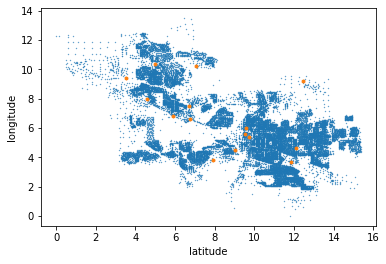

In [83]:
customer_locations = np.asarray(list(set(zip(raw.location_x, raw.location_y))))
customer_locations_x = [t[0] for t in customer_locations]
customer_locations_y = [t[1] for t in customer_locations]

restaurant_locations = list(set(zip(raw.restaurant_location_x, raw.restaurant_location_y)))
restaurant_locations_x = [t[0] for t in restaurant_locations]
restaurant_locations_y = [t[1] for t in restaurant_locations]

print(customer_locations.shape)
plt.scatter(customer_locations_x, customer_locations_y, s=0.1)
plt.scatter(restaurant_locations_x, restaurant_locations_y, s=10, marker="h")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.savefig("Plots/spatial_dist")

plt.show()

In [ ]:
X_example, y_example = make_regression(random_state=0, n_samples = 50, n_features=5, n_informative=5)
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_example[:, np.newaxis, 3],y_example)
prediction = linear_reg.predict(X_example[:, np.newaxis, 3])

In [ ]:
plt.scatter(X_example[:, np.newaxis, 3], y_example,color='g')
plt.plot(X_example[:, np.newaxis, 3], prediction)
plt.xlabel("Some feature")
plt.ylabel("Label")
plt.savefig("Plots/linear_reg_example.png", dpi=95)

plt.show()

# Train() of NN, temporary in this notebook

In [6]:
def train(model, data, feature_list, params):
    
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Importing data.")

    etd_dataset = ETDData(data=data, feature_list=feature_list, objective=model.name)
    split = DataSplit(etd_dataset, shuffle=True)
    trainloader, _, testloader = split.get_split(batch_size=params["batch_size"], num_workers=8)
    
    print("Start training.")
    patience = params["patience"]
    criterion = params["criterion"]  # define your loss function and optimizer
    optimizer = params["optimizer"]

    
    early_stopping = EarlyStopping(patience=params["patience"], verbose=True) 
    epochs = params["epochs"] # How many epochs do you want to train?
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.float().to(device)
            labels = labels.float().view(-1, model.view).to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.float().to(device)
                labels = labels.float().view(-1, model.view).to(device) 
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss / len(trainloader):.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. ")
        early_stopping(test_loss / len(testloader), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        model.train()
        
    print('Finished Training')
    #ae.load_state_dict(torch.load('checkpoint.pt'))
    #torch.save(ae, 'perceptron.pth')
    return model, abs(early_stopping.best_score)

# Study

## Part 1: Different sample sizes 

With the first part, we seek to examine the convergence behavior of our models and answer following question: How many samples are enough to train the model without ? 
We determine the answer to that question graphically. For that, we construct plots where the x-axis represents the number of samples used in the corresponding training instance, and the y-axis represents the corresponding L<sub>2</sub>-loss measured with the mean squared error.

### Define helper functions ###

In [ ]:
def plot_convergence(sample_sizes, results, title):
    plt.xlabel("Sample size")
    plt.ylabel("Mean squared error")
    plt.plot(sample_sizes, results)
    plt.savefig(f"Plots/{title}.png")

# Helper function for lightgbm
def best_iteration(evals_result):
    iterations = evals_result
    small = iterations[0]
    for i in iterations:
        if small > i:
            small = i
     
    return small    

### Test 1.1: Tree-based ensembles: GBDT and RF (LightGBM Implementation)

In [ ]:
### Convergence Test for LightGBM's GBDT ###
def gbdt_convergence(X, y, params, start=1000, stop=200000, step=1000, early_stopping_rounds=10):
    
    sample_sizes = np.arange(start=start, stop=stop, step=step)
    results = []
    
    evals_result = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
    
    for rows in sample_sizes:
        train_set = lgb.Dataset(X_train[:rows],y_train[:rows])
        val_set = lgb.Dataset(X_test[:rows], y_test[:rows], reference=train_set)
        
        bst = lgb.train(
            params,
            train_set=train_set,
            valid_sets=[val_set, train_set],
            evals_result = evals_result,
            early_stopping_rounds = early_stopping_rounds
        )
        best_iter = best_iteration(evals_result=dict(evals_result["valid_0"])["l2"])
        print(f"Best iteration: {best_iteration}")
        print(f"Lower bound value: {bst.upper_bound()}")
        results.append(best_iter)
    plot_convergence(sample_sizes, results, "GBDT_Convergence")


params_gbdt = {
    "boosting_type" : "gbdt",
    "metrics" : "l2",
    "learning_rate" : 0.02, 
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
    "n_estimators" : 1000,
}

params_rf = {
    "boosting_type" : "rf",
    "metrics" : "l2", 
    "n_estimators" : 1000,
    "bagging_fraction" : 0.632,
    "bagging_freq" : 1,
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
}

gbdt_convergence(X, y, params_rf, 10000, 11000, 1000)

### Test 1.2: Linear Regression

In [ ]:
### Convergence test for Scikit-Learn's Linear Regression ###
def lr_convergence(X, y, params=None, start=1000, stop=101000, step=1000):
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
    sample_sizes = np.arange(start=start, stop=stop, step=step)
    results = []
    
    for rows in sample_sizes:
        lr = LinearRegression()
        lr.fit(X_train[:rows], y_train[:rows])
        mse = mean_squared_error(y_test, lr.predict(X_test))
        print(f"Sample size - error: {rows} -> {mse}")
        results.append(mse)
    plot_convergence(sample_sizes, results, "LR_Convergence")

lr_convergence(X, y)

### Test 1.3: Random Forest

In [ ]:
### Convergence test for Scikit-Learn's Random Forest Regressor ###
def rf_convergence(X, y, params=None, start=1000, stop=101000, step=1000):
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
    sample_sizes = np.arange(start=start, stop=stop, step=step)
    results = []
    
    for rows in sample_sizes:
        rf = RandomForestRegressor(**params)
        rf.fit(X_train[:rows], y_train[:rows])
        mse = mean_squared_error(y_test, rf.predict(X_test))
        print(f"Sample size - error: {rows} -> {mse}")
        results.append(mse)
    plot_convergence(sample_sizes, results)
    
    
params = {
    "n_estimators" : 100,
    "n_jobs" : 6,
    "verbose" : 1,
    "random_state" : 42,
}

rf_convergence(X, y, params)

### Test 1.4: Single Layer Perceptron

In [7]:
sample_sizes = np.arange(start=20000, stop=22000, step=2000)
results = []

n_features = len(features)
n_hidden = math.ceil(n_features * (1 / 2))
n_code = math.ceil(n_hidden * (1 / 2))

ae = Autoencoder(n_features=n_features, n_hidden=n_hidden, n_code=n_code)
slp = Regressor(n_features = n_features, n_hidden = n_hidden, n_output = 1)

params = {
        "patience" : 10,
        "criterion" : nn.MSELoss(),
        "optimizer" : optim.Adam(slp.parameters(), lr=0.0001),
        "epochs" : 10,
        "batch_size" : 50,
}

#for rows in sample_sizes:
model, mse = train(slp, raw[:20000], features, params)
#    results.append(mse)
#plot_convergence(sample_sizes, results)

Importing data.
160000
Start training.


/home/emre/Bachelor/Implementation/utils.py:77: RuntimeWarning: invalid value encountered in true_divide
  self.normalized_samples = (self.samples - np.mean(self.samples, axis=0)) / np.std(self.samples, axis=0)


Epoch 1/10.. Train loss: nan.. Test loss: nan.. 
Validation loss decreased (inf --> nan).  Saving model ...


KeyboardInterrupt: 

## Part 2: Hyperparameter optimization

In [ ]:
def gbdt_opt(trial, X, y, boosting_type):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
    train_set = lgb.Dataset(X_train,y_train)
    valid_set = lgb.Dataset(X_test, y_test)
    
    params = {
        "gbdt" : {
            "boosting_type" : "gbdt",
            "metric" : "l2",
            "objective" : "regression",
            "learning_rate" : trial.suggest_uniform("learning_rate", 0.01, 0.05),
            "num_leaves" : trial.suggest_int("num_leaves", 30, 150),
            "min_child_samples" : trial.suggest_int("min_child_samples", 1, 20),
            "num_threads"  : 6,
            "random_state" : 42,
            "force_row_wise" : True, 
            "num_boost_round": 1000,
        },
        "rf" : {
            
        }      
    }
    evals_result = {}
    bst = lgb.train(
        params[boosting_type],
        train_set=train_set,
        valid_sets=[valid_set, train_set],
        valid_names=["Validation error", "Train error"],
        evals_result = evals_result,
        verbose_eval = 5,
    )
    preds = bst.predict(X_test)
    loss  = mean_squared_error(y_test, preds)
    return loss

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.CmaEsSampler(seed=42))
study.optimize(lambda trial: gbdt_opt(trial, X, y, "gbdt"), n_trials=1)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("Value: {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))   

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
def lr_opt(trial, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
    
    lr = linear_model.LinearRegression(),
    lr.fit(X_train, y_train)
    return mean_squared_error(y_test, lr.predict(X_test))

# Part 3: Introducing Noise

# NEURAL NETWORK (Pytorch)

# 1. Model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_code):
        super(Autoencoder, self).__init__()
        self.name = "ae"
        self.view = n_features
        self.hidden_enc = nn.Linear(n_features, n_hidden)
        self.encode = nn.Linear(n_hidden, n_code)
        self.hidden_dec = nn.Linear(n_code, n_hidden)
        self.decode = nn.Linear(n_hidden, n_features)

    def forward(self, x):
        x = F.leaky_relu(self.hidden_enc(x))
        x = F.leaky_relu(self.encode(x))
        x = F.leaky_relu(self.hidden_dec(x))
        x = self.decode(x)

        return x
    
class Regressor(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Regressor, self).__init__()
        self.name = "regressor"
        self.view = n_output
        self.hidden = nn.Linear(n_features, n_hidden)
        self.predict = nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = F.leaky_relu(self.hidden(x))
        x = self.predict(x)

        return x

## 2. Training loop

In [ ]:
import torch
from torch import nn, optim
from utils import *
    

def train(model, data, feature_list, fit_params):
    
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Importing data.")

    etd_dataset = ETDData(data=data, feature_list=feature_list, objective=model.name)
    split = DataSplit(etd_dataset, shuffle=True)
    trainloader, _, testloader = split.get_split(batch_size=params["batch_size"], num_workers=8)
    
    print("Start training.")
    patience = params["patience"]
    criterion = params["criterion"]  # define your loss function and optimizer
    optimizer = params["optimizer"]

    
    early_stopping = EarlyStopping(patience=params["patience"], verbose=True) 
    epochs = params["epochs"] # How many epochs do you want to train?
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.float().to(device)
            labels = labels.float().view(-1, model.view).to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.float().to(device)
                labels = labels.float().view(-1, model.view).to(device) 
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss / len(trainloader):.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. ")
        early_stopping(test_loss / len(testloader), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        model.train()
        
    print('Finished Training')
    #ae.load_state_dict(torch.load('checkpoint.pt'))
    #torch.save(ae, 'perceptron.pth')
    return model, abs(early_stopping.best_score)

## Main